In [33]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [34]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
import zipfile

z= zipfile.ZipFile('chest-xray-pneumonia.zip')
z.extractall()

In [36]:
!pip install tensorflow

In [37]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
2.15.0


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# Loading the dataset

In [39]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [40]:
train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-39-224b011a10db>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization and Preprocessing

In [41]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

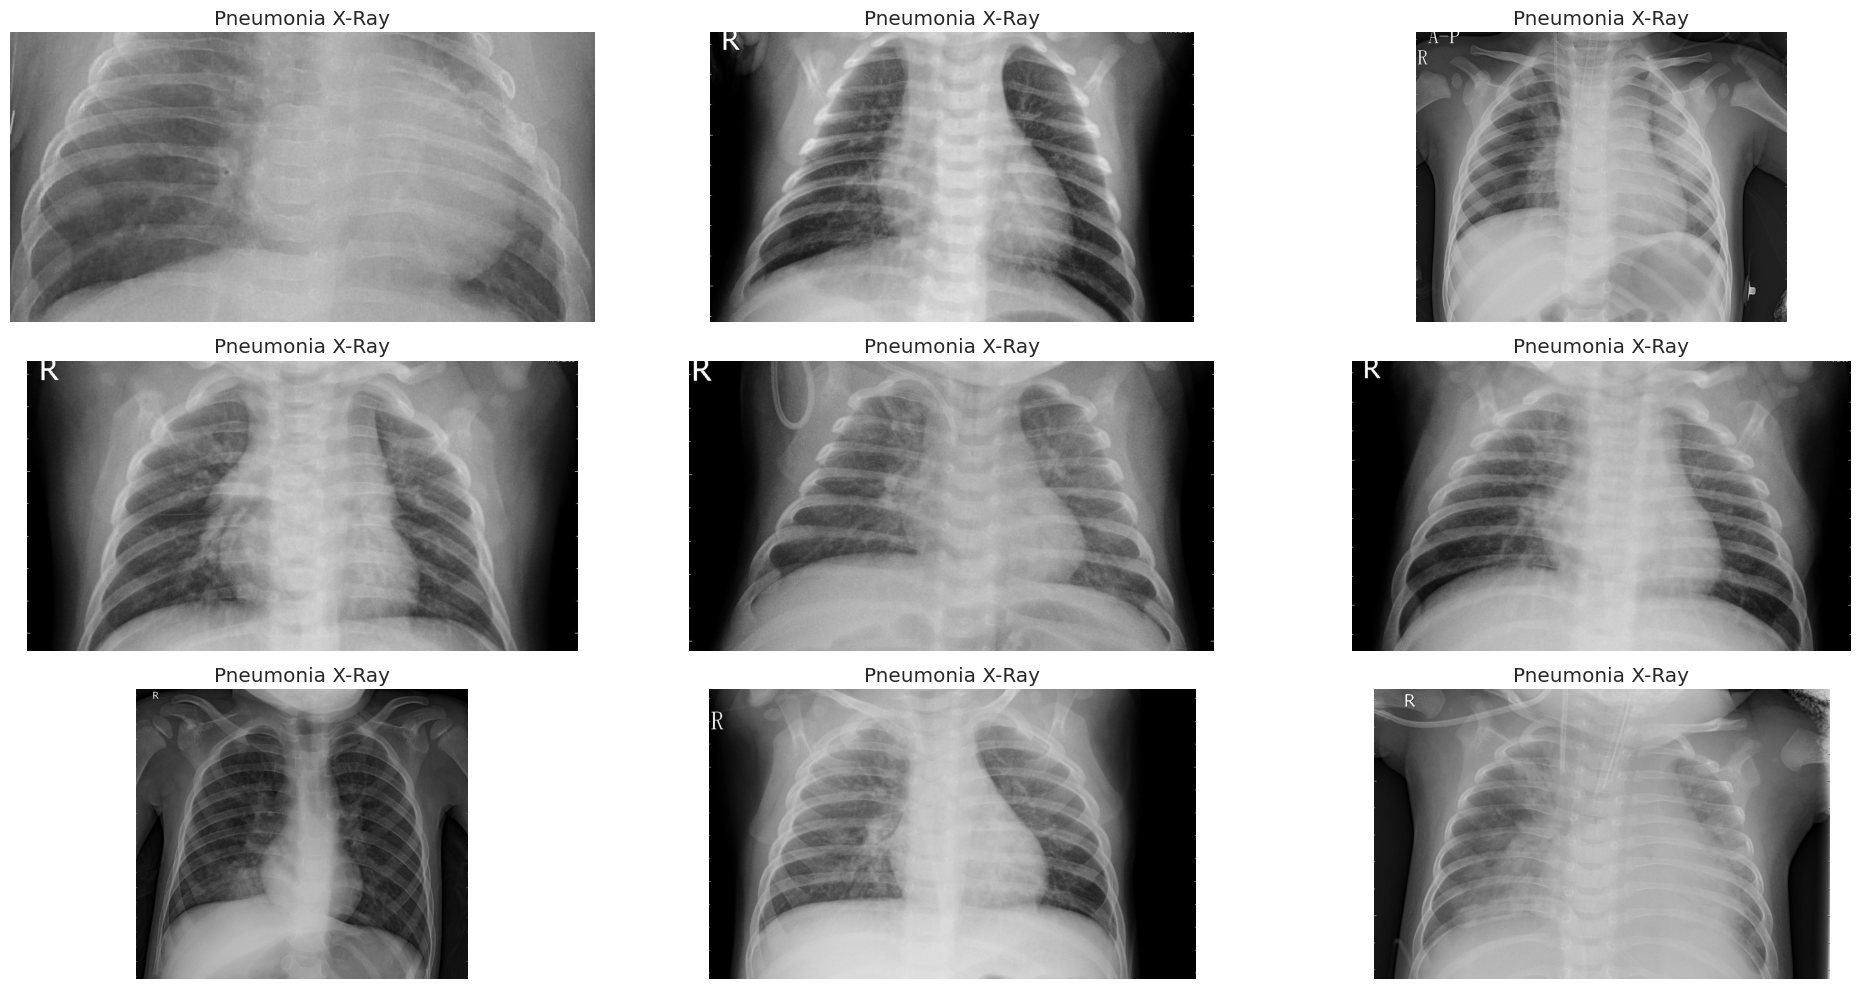

In [42]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()
# plt.savefig("outputs/pneumonia_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

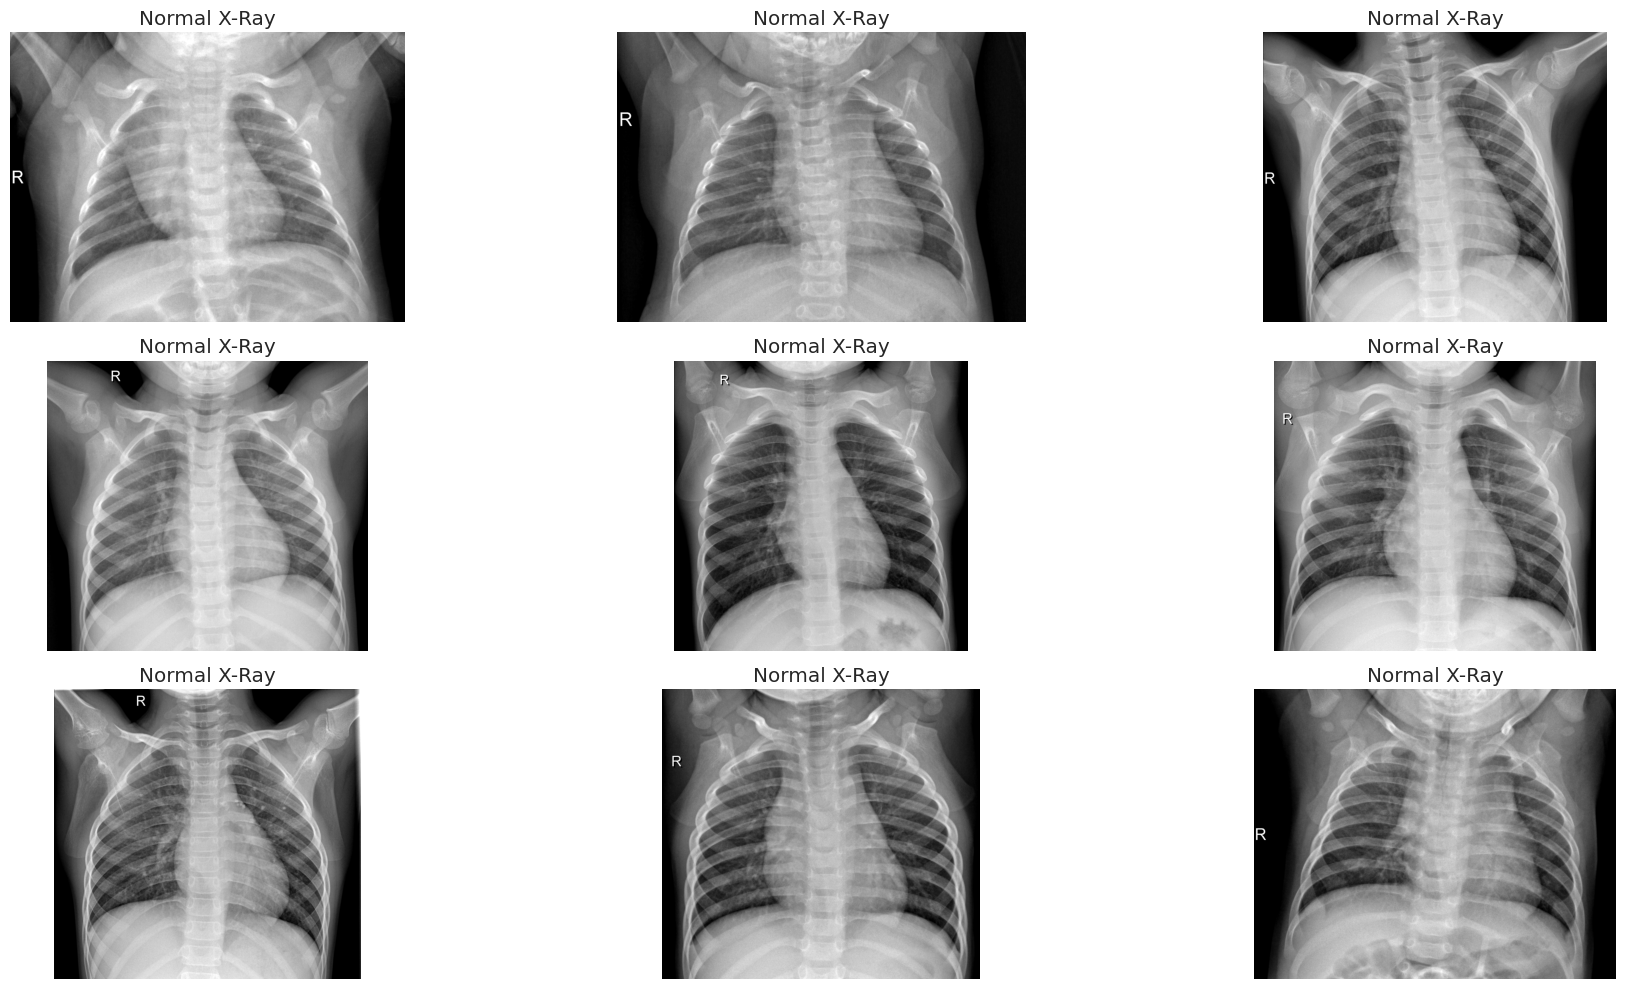

In [43]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray")

plt.tight_layout()
# plt.savefig("outputs/normal_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

<Axes: xlabel='count'>

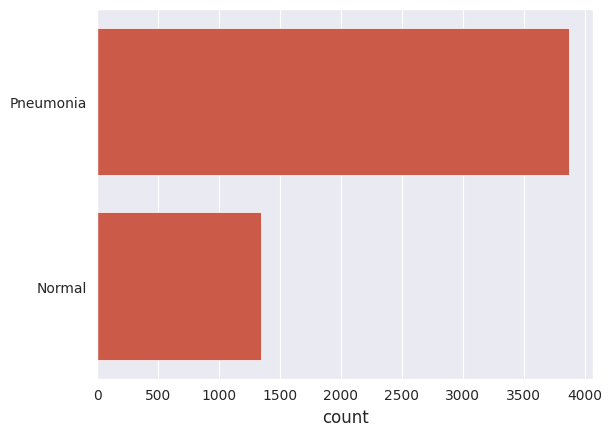

In [44]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.set_style('darkgrid')
sns.countplot(listx)

In [45]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"


normal_train = os.listdir("chest_xray/train/NORMAL")
normal_train_dir = "chest_xray/train/NORMAL"
normal_val = os.listdir("chest_xray/val/NORMAL")
normal_val_dir = "chest_xray/val/NORMAL"
normal_test = os.listdir("chest_xray/test/NORMAL")
normal_test_dir = "chest_xray/test/NORMAL"

pneumonia_train = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_train_dir = "chest_xray/train/PNEUMONIA"
pneumonia_val = os.listdir("chest_xray/val/PNEUMONIA")
pneumonia_val_dir = "chest_xray/val/PNEUMONIA"
pneumonia_test = os.listdir("chest_xray/test/PNEUMONIA")
pneumonia_test_dir = "chest_xray/test/PNEUMONIA"

In [46]:
print("{} Infected training images:".format(len(os.listdir(pneumonia_train_dir))))
print("{} Normal training images:".format(len(os.listdir(normal_train_dir))))
print(" {} Infected valid images:".format(len(os.listdir(pneumonia_val_dir))))
print(" {} Normal valid images:".format(len(os.listdir(normal_val_dir))))
print(" {} Infected testing images:".format(len(os.listdir(pneumonia_test_dir))))
print(" {} Normal testing images:".format(len(os.listdir(normal_test_dir))))

3875 Infected training images:
1341 Normal training images:
 8 Infected valid images:
 8 Normal valid images:
 390 Infected testing images:
 234 Normal testing images:


In [47]:
# Train
infected_trn_fpaths = [os.path.join(pneumonia_train_dir, fpath) for fpath in os.listdir(pneumonia_train_dir)]
healthy_trn_fpaths = [os.path.join(normal_train_dir, fpath) for fpath in os.listdir(normal_train_dir)]

# Valid
infected_valid_fpaths = [os.path.join(pneumonia_val_dir, fpath) for fpath in os.listdir(pneumonia_val_dir)]
healthy_valid_fpaths = [os.path.join(normal_val_dir, fpath) for fpath in os.listdir(normal_val_dir)]

# Test
infected_test_fpaths = [os.path.join(pneumonia_test_dir, fpath) for fpath in os.listdir(pneumonia_test_dir)]
healthy_test_fpaths = [os.path.join(normal_test_dir, fpath) for fpath in os.listdir(normal_test_dir)]

In [48]:
def get_img_shape(idx, img, total_num_images):

    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 5215


In [49]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [127 384   3]
Avg Dimensions:           [ 968.07476994 1320.61081288    3.        ]
Median Dimensions:        [ 888. 1284.    3.]
Most Frequent Dimensions: [ 736 1008    3]
Max Dimensions:           [2663 2916    3]


In [50]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

# Data augmentation and resizing images

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [52]:
class_labels, class_names

({'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'})

# Transfer Learning - VGG19 CNN Architecture

In [53]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False,
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'pneumonia.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [54]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7506
Epoch 1: val_loss improved from inf to 0.61354, saving model to pneumonia.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 27s 527ms/step - loss: 0.5468 - accuracy: 0.7506 - val_loss: 0.6135 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.7513
Epoch 2: val_loss did not improve from 0.61354
50/50 [==============================] - 22s 445ms/step - loss: 0.5013 - accuracy: 0.7513 - val_loss: 0.6867 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.7844
Epoch 3: val_loss improved from 0.61354 to 0.58156, saving model to pneumonia.h5
50/50 [==============================] - 24s 484ms/step - loss: 0.4439 - accuracy: 0.7844 - val_loss: 0.5816 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8037
Epoch 4: val_loss improved from 0.58156 to 0.53837, saving model to pneumonia.h5
50/50 [==============================] - 22s 448ms/step - loss

In [55]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='vgg19_model_01.h5', overwrite=True)

In [56]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 624 images belonging to 2 classes.


In [57]:
# Load the saved model
model_01.load_weights('vgg19_model_01.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

624/624 [==============================] - 7s 12ms/step - loss: 0.4655 - accuracy: 0.7756
Validation loss:     0.6043
Validation accuracy: 0.6250
Test loss:           0.4655
Test accuracy:       0.7756


In [58]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

624/624 [==============================] - 7s 11ms/step


# Incremental unfreezing and fine-tuning

In [59]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [60]:
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [61]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8031
Epoch 1: val_loss improved from 0.47621 to 0.42718, saving model to pneumonia.h5
10/10 [==============================] - 8s 744ms/step - loss: 0.4326 - accuracy: 0.8031 - val_loss: 0.4272 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8625
Epoch 2: val_loss did not improve from 0.42718
10/10 [==============================] - 4s 430ms/step - loss: 0.3246 - accuracy: 0.8625 - val_loss: 0.8147 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8219
Epoch 3: val_loss improved from 0.42718 to 0.38633, saving model to pneumonia.h5
10/10 [==============================] - 7s 672ms/step - loss: 0.3931 - accuracy: 0.8219 - val_loss: 0.3863 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.3432 - 

In [64]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

# Evaluating the model

624/624 [==============================] - 8s 12ms/step - loss: 0.3963 - accuracy: 0.8189
Validation loss:     0.7139981389045715
Validation accuracy: 0.6875
Test loss:           0.39633601903915405
Test accuracy:       0.8189102411270142
624/624 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

     healthy       0.91      0.57      0.70       234
    infected       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



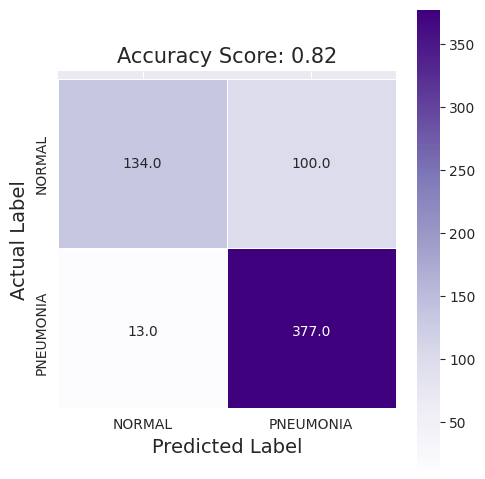

In [65]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02),
                        index=['NORMAL', 'PNEUMONIA'],
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

# Unfreezing and fine-tuning the entire network[link text

In [68]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('/content/model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
  history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.8975
Epoch 1: val_loss did not improve from 0.38633
100/100 [==============================] - 52s 431ms/step - loss: 0.2393 - accuracy: 0.8975 - val_loss: 0.7322 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/35
100/100 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9181
Epoch 2: val_loss did not improve from 0.38633
100/100 [==============================] - 42s 421ms/step - loss: 0.1987 - accuracy: 0.9181 - val_loss: 0.7976 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/35
100/100 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9281
Epoch 3: val_loss improved from 0.38633 to 0.35157, saving model to pneumonia.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 49s 492ms/step - loss: 0.1754 - accuracy: 0.9281 - val_loss: 0.3516 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/35
100/100 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9419
Epoch 4: val_loss improved from 0.35157 to 0.24142, saving model to pneumonia.h5
100/100 [==============================] - 48s 479ms/step - loss: 0.1502 - accuracy: 0.9419 - val_loss: 0.2414 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/35
100/100 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9463
Epoch 5: val_loss improved from 0.24142 to 0.16633, saving model to pneumonia.h5
100/100 [==============================] - 48s 479ms/step - loss: 0.1409 - accuracy: 0.9463 - val_loss: 0.1663 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/35
100/100 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9472
Epoch 6: val_loss improved from 0.16633 to 0.16005, saving model to pneumonia.h5
100/100 [=======

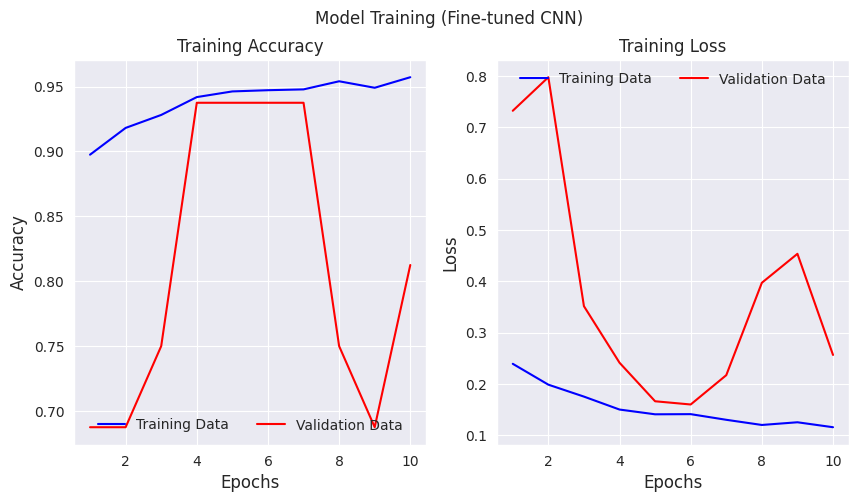

In [70]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
# plt.savefig("outputs/pneumonia_training_finetunedcnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [71]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)

# Evaluating the model

624/624 [==============================] - 7s 12ms/step - loss: 0.3355 - accuracy: 0.9071
Validation loss     :0.2566
Validation accuracy :0.8125
Test loss           :0.3355
Test accuracy       :0.9071
624/624 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

     healthy       0.98      0.77      0.86       234
    infected       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624



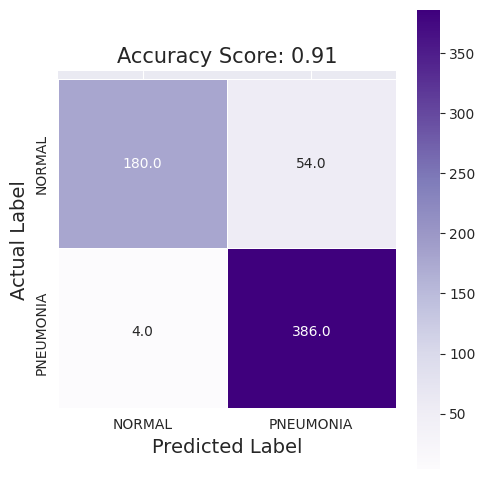

In [72]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03),
                        index=['NORMAL', 'PNEUMONIA'],
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

[80.13, 91.35]
[75.21, 89.15]


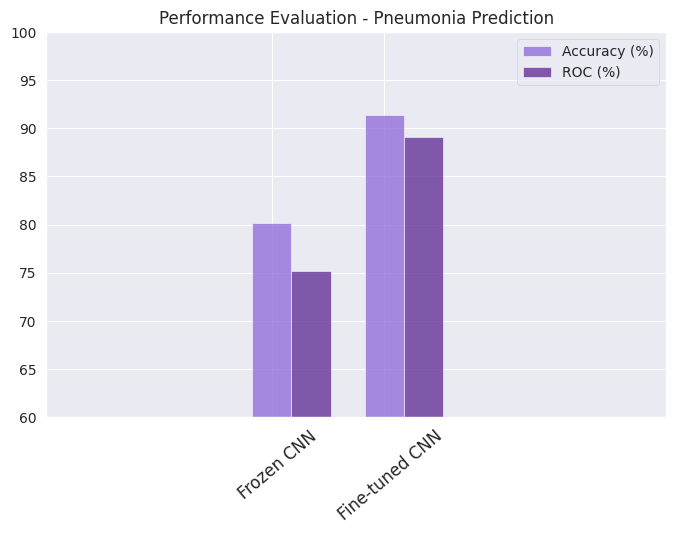

In [74]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test accuracy       :0.8013
# ROC                 :0.7521

# Test accuracy       :0.9135
# ROC                 :0.8915

means_roc = [75.21, 89.15]
means_accuracy = [80.13, 91.35]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.savefig("outputs/PE_pneumonia.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[43.31, 30.56]


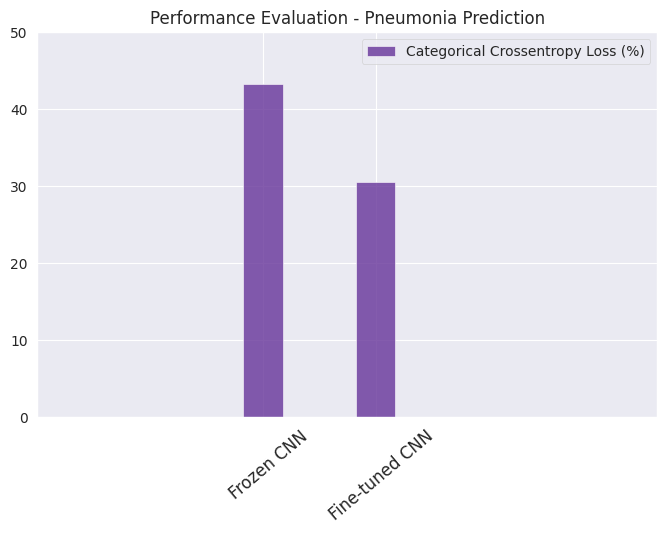

In [77]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test loss           :0.4331
# Test loss           :0.3056

means_loss = [43.31, 30.56]

print(means_loss)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity,
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("PE_pneumonia2.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Prediction results for 10 randomly selected images

In [78]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

1/1 [==============================] - 0s 22ms/step


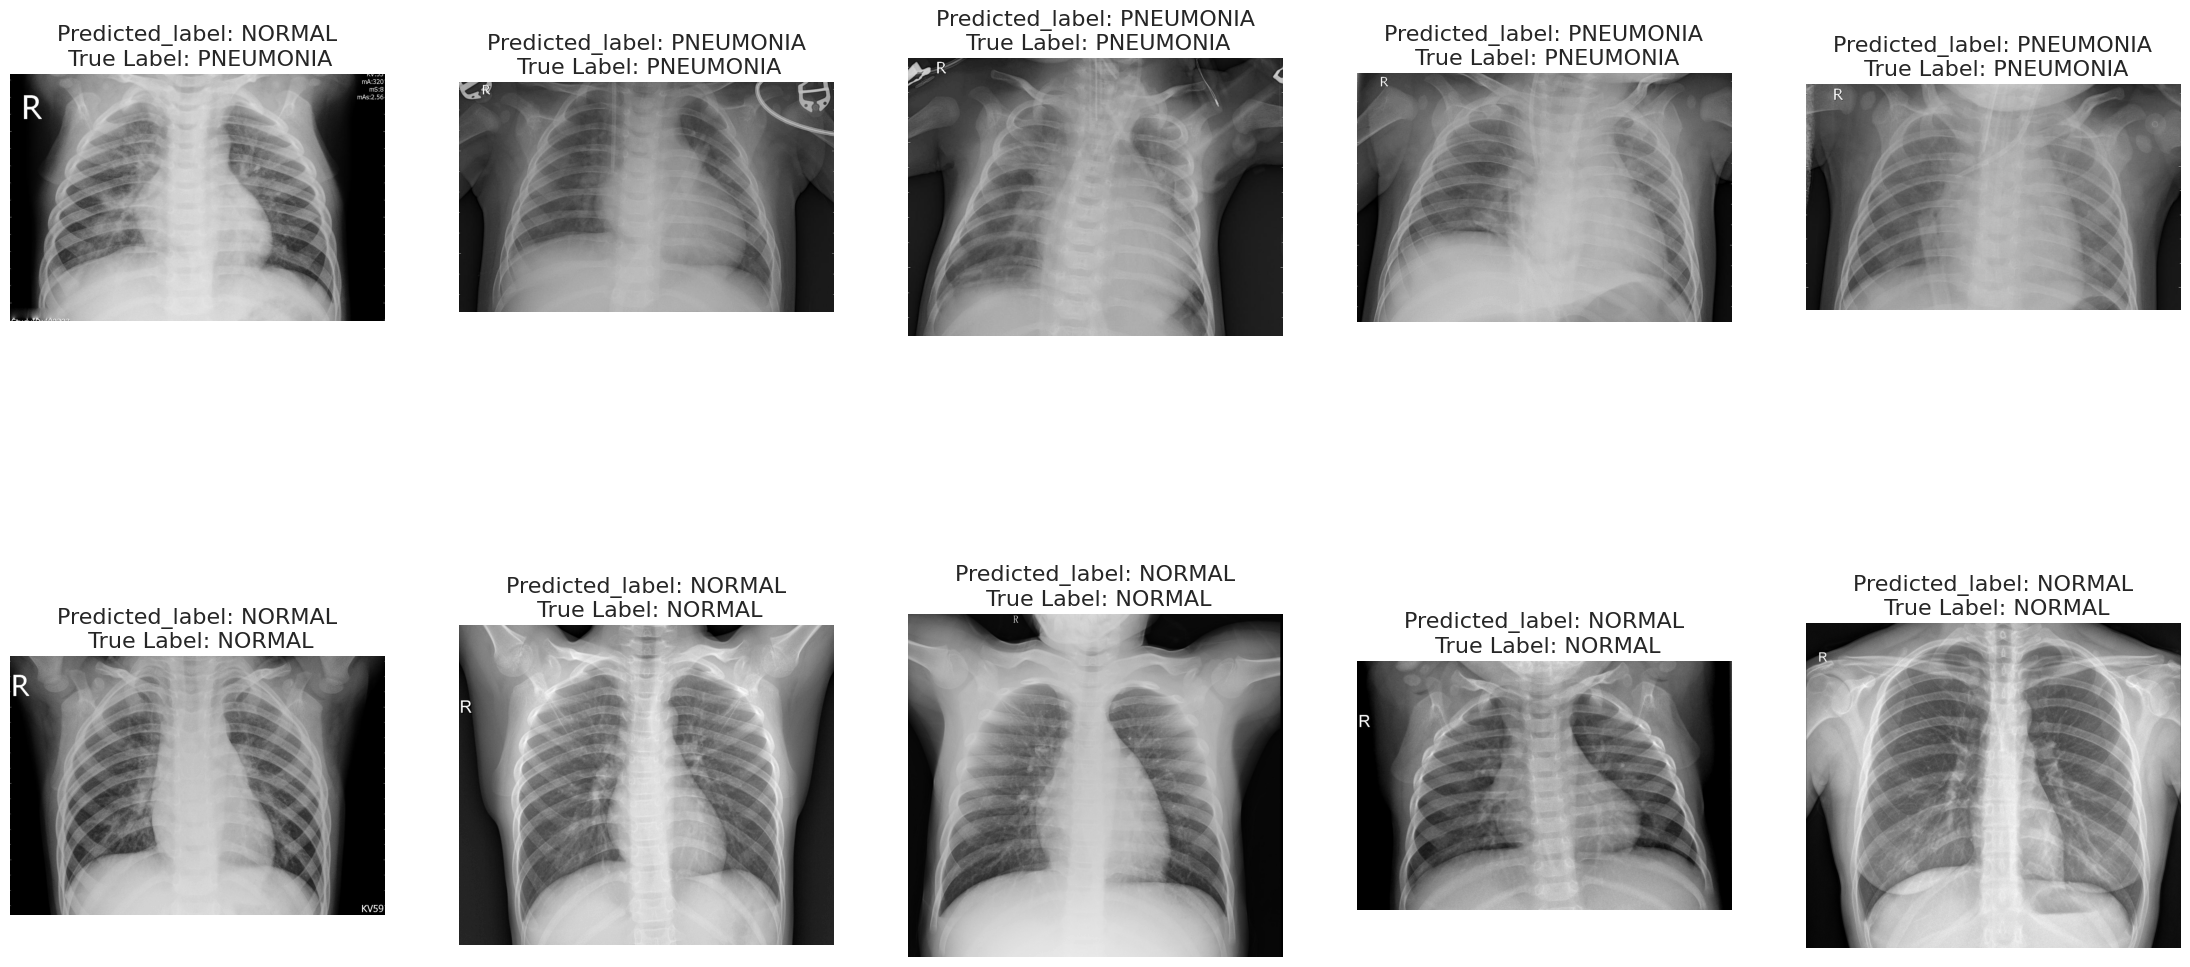

In [80]:
from keras.preprocessing.image import ImageDataGenerator
true_labels = []
predicted_labels = []
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128,128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=16)
# plt.savefig("pneumonia_predictions.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()